In [ ]:
!pip install --upgrade open_spiel

In [ ]:
import pandas as pd
import numpy as np
from statistics import mean, stdev

from matplotlib import pyplot as plt

import tensorflow as tf

# from open_spiel.python import policy
from open_spiel.python import rl_environment
from open_spiel.python.bots import human
from open_spiel.python.bots import uniform_random
from open_spiel.python import policy
from open_spiel.python.algorithms import deep_cfr_tf2
from open_spiel.python.algorithms import expected_game_score
from open_spiel.python.algorithms import evaluate_bots

import pyspiel
import gc

In [ ]:
device = tf.test.gpu_device_name() if tf.test.gpu_device_name() else "cpu"

In [ ]:
def load_bot(agent_type, game, player_id):
  """Return a bot based on the agent type."""
  SEED = 1234
  rng = np.random.RandomState(SEED)

  if agent_type == "random":
    return uniform_random.UniformRandomBot(player_id, rng)
  elif agent_type == "human":
    return human.HumanBot()
  elif agent_type == "check_call":
    policy = pyspiel.PreferredActionPolicy([1, 0])
    return pyspiel.make_policy_bot(game, player_id, SEED, policy)
  elif agent_type == "fold":
    policy = pyspiel.PreferredActionPolicy([0, 1])
    return pyspiel.make_policy_bot(game, player_id, SEED, policy)
  elif agent_type == "50/50_call_fold":
    policy = pyspiel.PreferredActionPolicy([1, 1])
    return pyspiel.make_policy_bot(game, player_id, SEED, policy)
  elif agent_type == "pot_sized_bet":
    policy = pyspiel.PreferredActionPolicy([0, 0, 1])
    return pyspiel.make_policy_bot(game, player_id, SEED, policy)
  elif agent_type == "all_in":
    policy = pyspiel.PreferredActionPolicy([0, 0, 0, 1])
    return pyspiel.make_policy_bot(game, player_id, SEED, policy)
  else:
    raise RuntimeError("Unrecognized agent type: {}".format(agent_type))

In [ ]:
class Agent(pyspiel.Bot):
    """Agent template"""

    def __init__(self, player_id, model):
        """Initialize an agent to play FCPA poker.
        Note: This agent should make use of a pre-trained policy to enter
        the tournament. Initializing the agent should thus take no more than
        a few seconds.
        """
        pyspiel.Bot.__init__(self)
        self.player_id = player_id
        # policy_network_layers=(64, 64, 64, 64)
        # model = deep_cfr_tf2.PolicyNetwork(input_size, policy_network_layers, num_actions)
        # model((tf.random.uniform(shape=(1, input_size)), tf.random.uniform(shape=(num_actions,))), training=False)
        # model.load_weights(check_point)
        self.policy_net = model


    def restart_at(self, state):
        """Starting a new game in the given state.
        :param state: The initial state of the game.
        """
        pass

    def inform_action(self, state, player_id, action):
        """Let the bot know of the other agent's actions.
        :param state: The current state of the game.
        :param player_id: The ID of the player that executed an action.
        :param action: The action which the player executed.
        """
        pass

    def step(self, state):
        input = state.information_state_tensor()
        input = tf.convert_to_tensor([input])
        # print(f'input shape: {input.shape}')
        # print(f'input: {input}')

        actions = state.legal_actions_mask(self.player_id)
        actions = tf.convert_to_tensor(actions)
        # print(f'action mask shape: {actions.shape}')
        # print(f'action mask: {actions}')

        output = self.policy_net((input, actions), training=False).numpy().reshape(-1)
        # print(output)
        # return np.argmax(output)
        return np.random.choice(len(output), p=output)


In [ ]:
def get_all_bot_types():
  return ['random', 
             'check_call', 
             'fold', 
             '50/50_call_fold',
             'pot_sized_bet', 
             'all_in']

In [ ]:
def eval_agent0_loop(policy_net, game, bot_type, eval_eps):
  learning_agents = [Agent(pid, policy_net) for pid in [0, 1]]
  bot_agents = [load_bot(bot_type, game, pid) for pid in [0, 1]]
  bots = [learning_agents[0], bot_agents[1]]

  wins = 0
  rewards = []

  for i in range(eval_eps):
    returns = evaluate_bots.evaluate_bots(game.new_initial_state(), bots, np.random)
    if returns[0] > returns[1]:
      wins += 1
    rewards.append(returns[0])
  
  # bots = [bot_agents[0], learning_agents[1]]
  # for i in range(eval_eps):
  #   returns = evaluate_bots.evaluate_bots(game.new_initial_state(), bots, np.random)
  #   if returns[1] > returns[0]:
  #     wins += 1
  #   rewards.append(returns[0])
  
  return wins/(eval_eps), np.mean(np.array(rewards))


In [ ]:
def eval_agent1_loop(policy_net, game, bot_type, eval_eps):
  learning_agents = [Agent(pid, policy_net) for pid in [0, 1]]
  bot_agents = [load_bot(bot_type, game, pid) for pid in [0, 1]]
  bots = [learning_agents[0], bot_agents[1]]

  wins = 0
  rewards = []

  # for i in range(eval_eps):
  #   returns = evaluate_bots.evaluate_bots(game.new_initial_state(), bots, np.random)
  #   if returns[0] > returns[1]:
  #     wins += 1
  #   rewards.append(returns[0])
  
  bots = [bot_agents[0], learning_agents[1]]
  for i in range(eval_eps):
    returns = evaluate_bots.evaluate_bots(game.new_initial_state(), bots, np.random)
    if returns[1] > returns[0]:
      wins += 1
    rewards.append(returns[0])
  
  return wins/(eval_eps), np.mean(np.array(rewards))


In [ ]:
def eval_with_all_bot_agent1(policy_net, game, eval_eps):
  rewards = []
  p_wins = []

  for bot_type in get_all_bot_types(): 
    reward, pwin = eval_agent1_loop(policy_net, game, bot_type, eval_eps)
    rewards.append(reward)
    p_wins.append(pwin)

  return rewards, p_wins

def eval_with_all_bot_agent0(policy_net, game, eval_eps):
  rewards = []
  p_wins = []

  for bot_type in get_all_bot_types(): 
    reward, pwin = eval_agent0_loop(policy_net, game, bot_type, eval_eps)
    rewards.append(reward)
    p_wins.append(pwin)

  return rewards, p_wins


In [ ]:
def eval_check_point():
  fcpa_game_string = (
      "universal_poker(betting=nolimit,numPlayers=2,numRounds=4,blind=150 100,"
      "firstPlayer=2 1 1 1,numSuits=4,numRanks=13,numHoleCards=2,numBoardCards=0 3 1 1,"
      "stack=20000 20000,bettingAbstraction=fcpa)")

  game = pyspiel.load_game(fcpa_game_string)
  input_size = len(game.new_initial_state().information_state_tensor(0))
  policy_network_layers=(64, 64, 64, 64)
  num_actions = game.num_distinct_actions()

  print(f'game has input size {input_size} and {num_actions} actions ')
  
  model = deep_cfr_tf2.PolicyNetwork(input_size, policy_network_layers, num_actions)
  model((tf.random.uniform(shape=(1, input_size)), tf.random.uniform(shape=(num_actions,))), training=False)
  model.load_weights('/tmp/policy_model_it8.h5')

  p_wins, avg_rewards = eval_loop(model, game, 'random', 100)
  print(f'random bot: p-win={p_wins}, avg_rewards={avg_rewards}')

  p_wins, avg_rewards = eval_loop(model, game, 'check_call', 100)
  print(f'check-call bot: p-win={p_wins}, avg_rewards={avg_rewards}')

  p_wins, avg_rewards = eval_loop(model, game, 'all_in', 100)
  print(f'all-in bot: p-win={p_wins}, avg_rewards={avg_rewards}')

# eval_check_point()

In [ ]:
num_iterations = 50
fcpa_game_string = (
    "universal_poker(betting=nolimit,numPlayers=2,numRounds=4,blind=150 100,"
    "firstPlayer=2 1 1 1,numSuits=4,numRanks=13,numHoleCards=2,numBoardCards=0 3 1 1,"
    "stack=20000 20000,bettingAbstraction=fcpa)")

game = pyspiel.load_game(fcpa_game_string)

deep_cfr_solver = deep_cfr_tf2.DeepCFRSolver(
    game,
    policy_network_layers=(256, 128),
    advantage_network_layers=(256, 128),
    num_iterations=1,
    num_traversals=200,
    learning_rate=1e-3,
    batch_size_advantage=1024,
    batch_size_strategy=1024,
    memory_capacity=int(1e5),
    policy_network_train_steps=500,
    advantage_network_train_steps=500,
    reinitialize_advantage_networks=False,
    infer_device=device,
    train_device=device)

losses_list = []
adv_loss_list = []
rewards_list = []
p_win_list = []
eval_eps = 100
bot_types = ['random', 
             'check_call', 
             'fold', 
             '50/50_call_fold',
             'pot_sized_bet', 
             'all_in']

for i in range(num_iterations):
  print('-' * 80)
  print(f'epoch {i}')
  policy_network, advantage_losses, policy_loss = deep_cfr_solver.solve()
  policy_network.save_weights(f"/tmp/policy_(256, 128)_model_it{i}.h5")

  adv_pair = []
  for player, losses in advantage_losses.items():
    adv_loss = mean([loss.numpy() for loss in losses])
    adv_pair.append(adv_loss)

  adv_loss_list.append(adv_pair)
  print("Final advantage loss: '{}'".format(adv_pair))
  print("Final policy loss: '{}'".format(float(policy_loss)))
  losses_list.append(float(policy_loss))

  p_win0, avg_reward0 = eval_with_all_bot_agent0(policy_network, game, eval_eps)
  p_win1, avg_reward1 = eval_with_all_bot_agent1(policy_network, game, eval_eps)
  rewards_list.append((avg_reward0, avg_reward1))
  p_win_list.append((p_win0, p_win1))

  print("avg_reward0={}-mean={}\navg_reward1={}-mean={}\np-win0={}\np-win1={}".format(avg_reward0, mean(avg_reward0), avg_reward1, mean(avg_reward1), p_win0, p_win1))
  
  gc.collect()


avg_reward0=[-248.0, -1537.0, 100.0, 994.5, 100.0, 100.0]-mean=-81.75
avg_reward1=[1308.5, 666.0, -73.5, -1195.0, -82.5, -92.0]-mean=88.58333333333333
p-win0=[0.6, 0.42, 1.0, 0.48, 1.0, 1.0]
p-win1=[0.38, 0.3, 0.7, 0.36, 0.73, 0.77]
--------------------------------------------------------------------------------
epoch 41
Final advantage loss: '[66011744.0, 72883580.0]'
Final policy loss: '0.03406338393688202'
avg_reward0=[-1331.5, 3154.5, 100.0, 1594.0, 100.0, 100.0]-mean=619.5
avg_reward1=[-2023.5, -2157.0, -77.0, 1058.5, -100.0, -56.5]-mean=-559.25
p-win0=[0.61, 0.56, 1.0, 0.5, 1.0, 1.0]
p-win1=[0.44, 0.4, 0.71, 0.29, 0.8, 0.63]
--------------------------------------------------------------------------------
epoch 42
Final advantage loss: '[67665810.0, 73923750.0]'
Final policy loss: '0.02754899486899376'
avg_reward0=[-429.0, 180.0, 100.0, 1152.0, 100.0, 100.0]-mean=200.5
avg_reward1=[1348.5, 2068.5, -85.0, -3626.0, -67.5, -82.5]-mean=-74.0
p-win0=[0.53, 0.49, 1.0, 0.52, 1.0, 1.0]
p-

In [ ]:
figsize = (6, 5)
output_dir_prefix = "/content/outputs/"
output_dir = output_dir_prefix + 'deep_cfr'
save_every = 1
import os

# Create directories for outputs
if os.path.exists(output_dir_prefix) == False:
  os.mkdir(output_dir_prefix)
if os.path.exists(output_dir) == False:
  os.mkdir(output_dir)

agent0_dir = output_dir + "/agent_0";
if os.path.exists(agent0_dir) == False:
  os.mkdir(agent0_dir)

agent1_dir = output_dir + "/agent_1";
if os.path.exists(agent1_dir) == False:
  os.mkdir(agent1_dir)

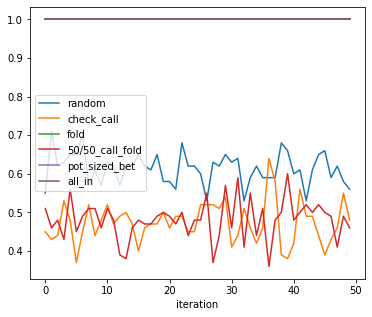

In [ ]:
fig = plt.figure(figsize=figsize)
pwins_agent1 = [pwins[0] for pwins in p_win_list]
x = list(save_every * np.arange(len(pwins_agent1)))

for i, bot_type in enumerate(bot_types):
  plt.plot(x, [wrs[i] for wrs in pwins_agent1], label = f"{bot_type}")


plt.xlabel("iteration")
# plt.ylim(0, 1e10)
plt.legend()
plt.savefig(agent0_dir + f"/winrates.png")
plt.show()


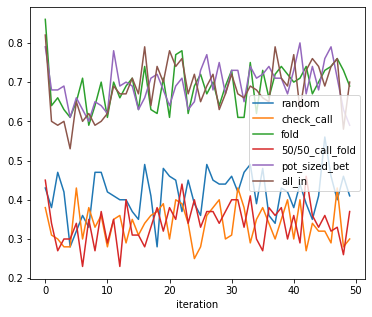

In [ ]:
fig = plt.figure(figsize=figsize)
pwins_agent1 = [pwins[1] for pwins in p_win_list]
x = list(save_every * np.arange(len(pwins_agent1)))

for i, bot_type in enumerate(bot_types):
  plt.plot(x, [wrs[i] for wrs in pwins_agent1], label = f"{bot_type}")


plt.xlabel("iteration")
# plt.ylim(0, 1e10)
plt.legend()
plt.savefig(agent1_dir + f"/winrates.png")
plt.show()


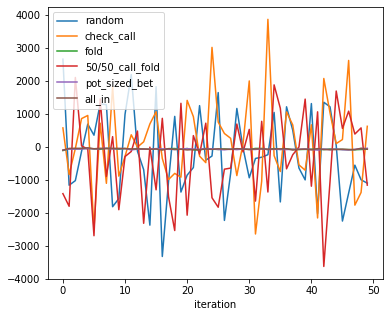

In [ ]:
fig = plt.figure(figsize=figsize)
pwins_agent1 = [pwins[1] for pwins in rewards_list]
x = list(save_every * np.arange(len(pwins_agent1)))

for i, bot_type in enumerate(bot_types):
  plt.plot(x, [wrs[i] for wrs in pwins_agent1], label = f"{bot_type}")


plt.xlabel("iteration")
# plt.ylim(0, 1e10)
plt.legend()
plt.savefig(agent1_dir + f"/avg_reward.png")
plt.show()
  

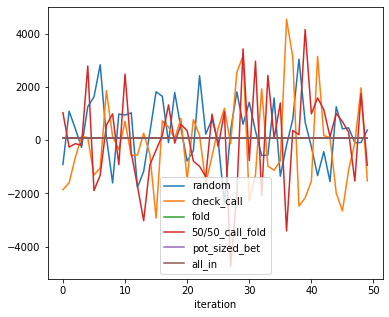

In [ ]:
fig = plt.figure(figsize=figsize)
pwins_agent1 = [pwins[0] for pwins in rewards_list]
x = list(save_every * np.arange(len(pwins_agent1)))

for i, bot_type in enumerate(bot_types):
  plt.plot(x, [wrs[i] for wrs in pwins_agent1], label = f"{bot_type}")


plt.xlabel("iteration")
# plt.ylim(0, 1e10)
plt.legend()
plt.savefig(agent0_dir + f"/avg_reward.png")
plt.show()


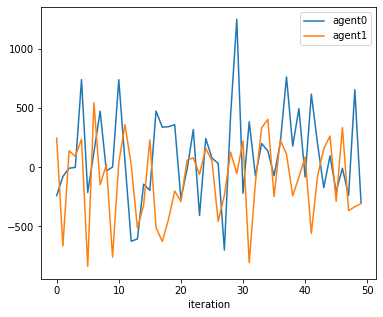

In [ ]:
fig = plt.figure(figsize=figsize)
pwins_agent1 = [pwins[0] for pwins in rewards_list]
x = list(save_every * np.arange(len(pwins_agent1)))
plt.plot(x, [mean(wrs) for wrs in pwins_agent1], label = 'agent0')

pwins_agent1 = [pwins[1] for pwins in rewards_list]
x = list(save_every * np.arange(len(pwins_agent1)))
plt.plot(x, [mean(wrs) for wrs in pwins_agent1], label = 'agent1')

plt.xlabel("iteration")
# plt.ylim(0, 1e10)
plt.legend()
plt.savefig(output_dir + f"/avg_mean_reward.png")
plt.show()


No handles with labels found to put in legend.


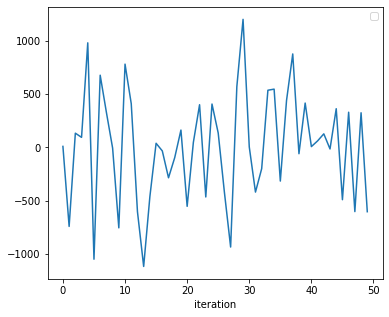

In [ ]:
fig = plt.figure(figsize=figsize)
x = list(save_every * np.arange(len(pwins_agent1)))

pwins_agent1 = [pwins[0] for pwins in rewards_list]
gain0 = np.array([mean(wrs) for wrs in pwins_agent1])

pwins_agent1 = [pwins[1] for pwins in rewards_list]
gain1 = np.array([mean(wrs) for wrs in pwins_agent1])

gain = gain0 + gain1

plt.plot(x, gain)



plt.xlabel("iteration")
# plt.ylim(0, 1e10)
plt.legend()
plt.savefig(output_dir + f"/avg_mean_gain_reward.png")
plt.show()


In [ ]:

print(adv_loss_list)

[[109530130.0, 185208380.0], [88075720.0, 103602150.0], [61642490.0, 72597010.0], [43506100.0, 55542960.0], [33478784.0, 48997290.0], [29256704.0, 46656360.0], [28115158.0, 49594430.0], [26468396.0, 42510828.0], [33699144.0, 42906764.0], [35850040.0, 41794016.0], [36260544.0, 43742740.0], [38391176.0, 45215090.0], [44751720.0, 45857450.0], [42463280.0, 47403100.0], [41934764.0, 48005468.0], [48314370.0, 49323370.0], [47631616.0, 57064692.0], [49728628.0, 54878348.0], [53776868.0, 54326560.0], [51095496.0, 57168320.0], [55276580.0, 56934230.0], [57120500.0, 63876176.0], [62028056.0, 59508756.0], [55572604.0, 62183360.0], [62190184.0, 65623304.0], [51509976.0, 61568252.0], [64717864.0, 63387388.0], [62266410.0, 61191160.0], [60685304.0, 65537164.0], [62041756.0, 63538396.0], [66904870.0, 69075870.0], [59781404.0, 66087884.0], [71952184.0, 65889304.0], [66498500.0, 68319280.0], [68897736.0, 73594344.0], [68505304.0, 69793010.0], [70109750.0, 74055660.0], [67997790.0, 67237830.0], [7069536

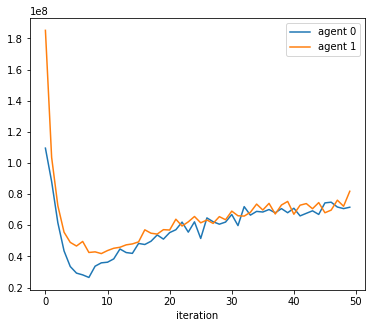

In [ ]:
fig = plt.figure(figsize=figsize)
x = list(save_every * np.arange(len(adv_loss_list)))

plt.plot(x, [loss[0] for loss in adv_loss_list], label = "agent 0")
plt.plot(x, [loss[1] for loss in adv_loss_list], label = "agent 1")

plt.xlabel("iteration")
plt.legend()
plt.savefig(output_dir + f"/adv_loss.png")
plt.show()

No handles with labels found to put in legend.


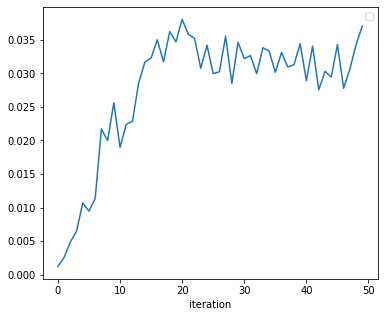

In [ ]:
fig = plt.figure(figsize=figsize)
x = list(save_every * np.arange(len(adv_loss_list)))

plt.plot(x, losses_list)

plt.xlabel("iteration")
plt.legend()
plt.savefig(output_dir + f"/policy_loss.png")
plt.show()

In [ ]:
!zip -r '/content/outputs.zip' '/content/outputs'


  adding: content/outputs/ (stored 0%)
  adding: content/outputs/deep_cfr/ (stored 0%)
  adding: content/outputs/deep_cfr/adv_loss.png (deflated 4%)
  adding: content/outputs/deep_cfr/avg_mean_gain_reward.png (deflated 4%)
  adding: content/outputs/deep_cfr/avg_mean_reward.png (deflated 2%)
  adding: content/outputs/deep_cfr/agent_0/ (stored 0%)
  adding: content/outputs/deep_cfr/agent_0/winrates.png (deflated 4%)
  adding: content/outputs/deep_cfr/agent_0/avg_mean_reward.png (deflated 2%)
  adding: content/outputs/deep_cfr/agent_0/.ipynb_checkpoints/ (stored 0%)
  adding: content/outputs/deep_cfr/agent_0/avg_reward.png (deflated 2%)
  adding: content/outputs/deep_cfr/policy_loss.png (deflated 7%)
  adding: content/outputs/deep_cfr/agent_1/ (stored 0%)
  adding: content/outputs/deep_cfr/agent_1/winrates.png (deflated 1%)
  adding: content/outputs/deep_cfr/agent_1/avg_reward.png (deflated 2%)
